# Twitter - Account Analytics
- **Created by Andrés Segura Tinoco**
- **Created on May 24, 2020**

In [1]:
# Import util libraries
import tweepy
import random
import numpy as np
import pandas as pd
import yaml
import warnings
from collections import Counter
from PIL import Image

In [2]:
# Import NLP libraries
import re
import spacy.lang.es as es
import spacy.lang.en as en
from wordcloud import WordCloud

In [3]:
# Import plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
warnings.filterwarnings('ignore')

## 1. Create connection to the Tweepy API

In [5]:
# Util function - Read dict from yaml file
def get_dict_from_yaml(yaml_path):
    result = dict()
    
    with open(yaml_path) as f:
        yaml_file = f.read()
        result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
    return result

In [6]:
# Read twitter bot credentials
yaml_path = 'config\credentials.yml'
twt_login = get_dict_from_yaml(yaml_path)

# Setup local credentials
consumer_key = twt_login['consumer_key']
consumer_secret = twt_login['consumer_secret']
access_token = twt_login['access_token']
access_token_secret = twt_login['access_token_secret']

## 2. Read an account's tweet list

In [7]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)

In [8]:
# Util function - Fetch tweets list from a specific user
# Twitter only allows access to a users most recent 3240 tweets with this method
def get_all_tweets(api, screen_name):
    all_tweets = []
    
    # Make initial request for most recent tweets (200 is the maximum allowed count)
    try:
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended')

        # Save most recent tweets
        all_tweets.extend(new_tweets)

        # Save the id of the oldest tweet less one
        oldest = all_tweets[-1].id - 1

        # Keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:

            # All subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name, count=200, tweet_mode='extended', max_id=oldest)

            # Save most recent tweets
            all_tweets.extend(new_tweets)

            # Update the id of the oldest tweet less one
            oldest = all_tweets[-1].id - 1
    
    except (socket.timeout, exceptions.ReadTimeoutError, exceptions.ProtocolError, tweepy.TweepError) as e:
        print('Error:', e)
    
    # Transform the tweepy tweets into an array that contains the relevant fields of each tweet
    tweet_list = []
    for tweet in all_tweets:
        tweet = {
            'id': tweet.id_str,
            'created_at': tweet.created_at,
            'full_text': tweet.full_text,
            'lang': tweet.lang,
            'hashtags': [ht['text'] for ht in tweet.entities['hashtags']],
            'retweet_count': tweet.retweet_count,
            'favorite_count': tweet.favorite_count,
        }
        tweet_list.append(tweet)
    
    return tweet_list

In [9]:
# Fetching tweet list from a specific user
user_name = "@SeguraAndres7"
tweet_list = get_all_tweets(api, user_name)

In [10]:
# Show the last tweet
tweet_list[0]

{'id': '1264653570059755523',
 'created_at': datetime.datetime(2020, 5, 24, 20, 24, 41),
 'full_text': "If you want to learn about Data Analytics, Machine Learning and Statistics in a fun but modern and formal way, I recommend @quaesita's blogs: \n\n➡️https://t.co/BiAMiwZ9BZ (en)\n➡️https://t.co/9oXa7PtFt2 (es)",
 'lang': 'en',
 'hashtags': [],
 'retweet_count': 1,
 'favorite_count': 2}

## 3. Analytics of Tweets

### 3.1. Basic Statistics

In [11]:
# Basic stats
n_tweets = len(tweet_list)
tweets_len = []

for tweet in tweet_list:
    tweets_len.append(len(tweet['full_text']))

print('Number of tweets:', n_tweets)
print('Minimum length:', np.min(tweets_len))
print('Maximum length:', np.max(tweets_len))
print('Average length:', np.mean(tweets_len))
print('Standard deviation:', np.std(tweets_len))

Number of tweets: 190
Minimum length: 15
Maximum length: 304
Average length: 145.60526315789474
Standard deviation: 79.58376569233737


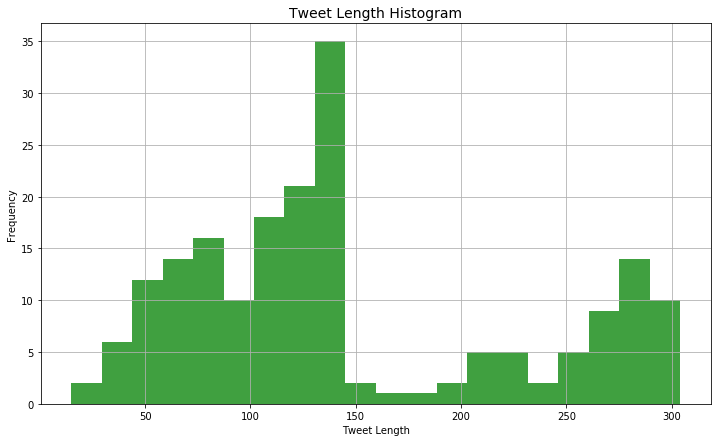

In [12]:
# Plot histograma of the tweet length
fig = plt.figure(figsize = (12, 7))
plt.hist(tweets_len, 20, facecolor='green', alpha=0.75)
plt.title('Tweet Length Histogram', fontsize = 14)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 3.2. Tweets Language

In [13]:
# Count the language of the tweets
lang_list = Counter()
lang_dict = {'en': 'English', 'es': 'Spanish', 'de': 'Deutsch'}

for tweet in tweet_list:
    lang = lang_dict[tweet['lang']]
    lang_list[lang] += 1

df = pd.DataFrame.from_records(lang_list.most_common(), columns = ['language', 'frequency'])

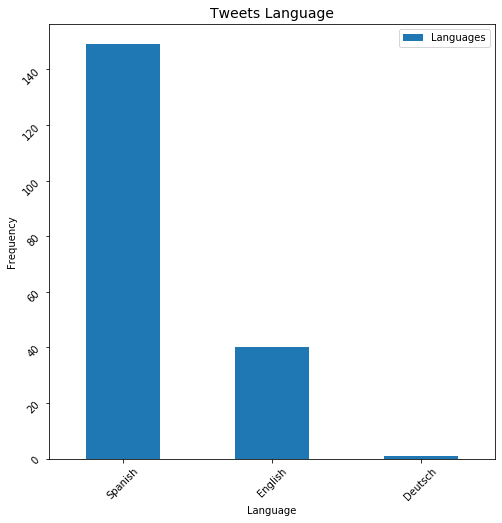

In [14]:
# Plot the most common words in the document
fig, ax = plt.subplots()
ax = df.plot.bar(ax=ax, x='language', y='frequency', figsize=(8, 8))
ax.legend(['Languages'])
ax.tick_params(rotation=45)
plt.title('Tweets Language', fontsize = 14)
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

### 3.3. Most used Hashtags in Tweets

In [15]:
# Count the hashtags in the tweets and return the N most repeated 
n_top = 20
hashtags = Counter()

for t in tweet_list:
    for ht in t['hashtags']:
        hashtags[ht] += 1

top_hashtags = hashtags.most_common(n_top)
df = pd.DataFrame.from_records(top_hashtags, columns = ['hashtag', 'frequency']).sort_values(by=['frequency'])

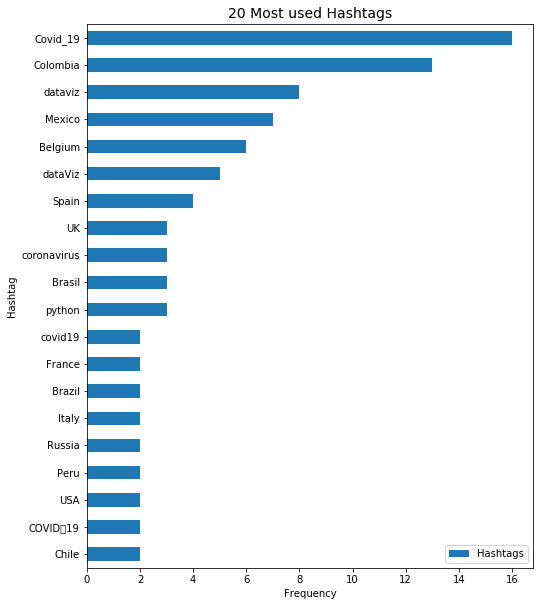

In [16]:
# Plot the most common words in the document
fig, ax = plt.subplots()
ax = df.plot.barh(ax=ax, x='hashtag', y='frequency', figsize=(8, 10))
ax.legend(['Hashtags'])
plt.title('%s Most used Hashtags' % n_top, fontsize = 14)
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

### 3.4. Most common Words in Tweets

In [17]:
# Data Quality process by sentence
sentence_list = []

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['full_text']
    
    # Cleaing the text
    clean_text = tweet_text.lower()
    clean_text = clean_text.replace('\n', '.')
    clean_text = re.sub('[^a-záéíóú0-9_.]', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    clean_text = re.sub(r'\.+', ".", clean_text)
    
    for sentence in clean_text.split('.'):
        if sentence != '':
            sentence_list.append(sentence.strip())

print('n sentences:', len(sentence_list))

n sentences: 516


In [18]:
# Word list counter
word_list = Counter()

for sentence in sentence_list:
    for word in sentence.split():
        word_list[word] += 1

top_words = word_list.most_common(n_top)
df = pd.DataFrame.from_records(top_words, columns = ['word', 'frequency']).sort_values(by=['frequency'])

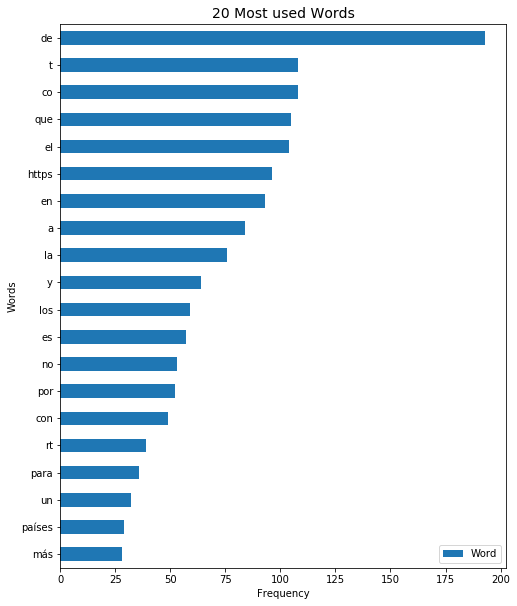

In [19]:
# Plot the most common words in the document
fig, ax = plt.subplots()
ax = df.plot.barh(ax=ax, x='word', y='frequency', figsize=(8, 10))
ax.legend(['Word'])
plt.title('%s Most used Words' % n_top, fontsize = 14)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

### 3.5. Most common Words w/o Stopwords

In [20]:
# Get Spanish stopwords
stopwords_es = es.stop_words.STOP_WORDS
stopwords_en = en.stop_words.STOP_WORDS

In [21]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter English and Spanihs stopwords
for word, freq in word_list.most_common():
    if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2):
        df.loc[ix] = (word, freq)
        ix += 1
    if ix == n_top:
        break

df = df.sort_values(by=['frequency'])

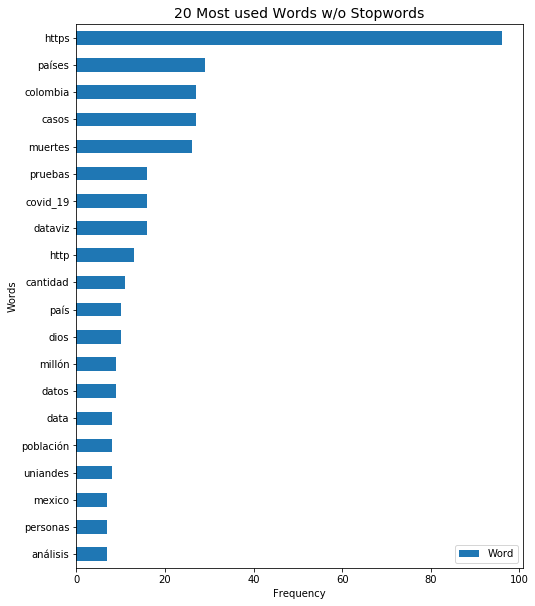

In [22]:
# Plot the most common words in the document
fig, ax = plt.subplots()
ax = df.plot.barh(ax=ax, x='word', y='frequency', figsize=(8, 10))
ax.legend(['Word'])
plt.title('%s Most used Words w/o Stopwords' % n_top, fontsize = 14)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

## 4. Wordcloud

In [23]:
# Reconstructing the clean text (without stop-words)
new_clean_text = ''
for sentence in sentence_list:
    for word in sentence.split():
        if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2):
            new_clean_text = new_clean_text + word + ' '

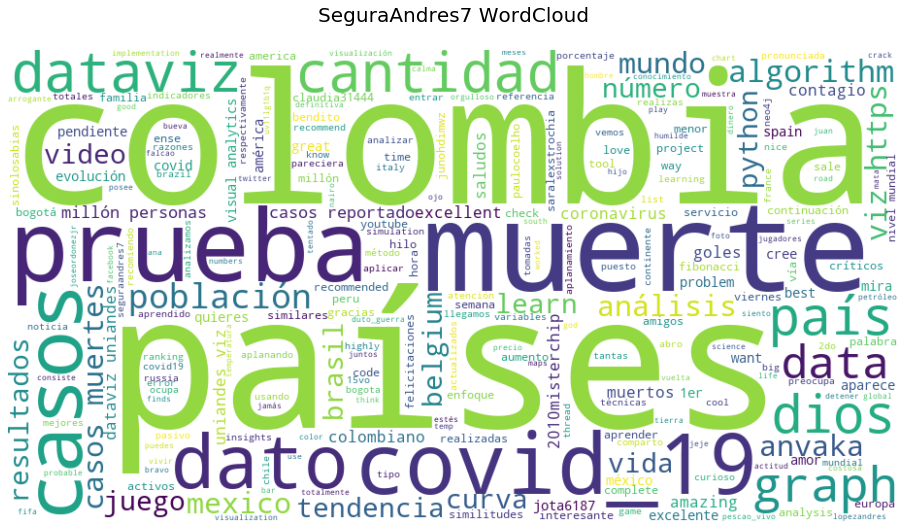

In [24]:
# Import mask
mask = np.array(Image.open('../img/twitter-mask.png'))

# Create a Word cloud
wc = WordCloud(background_color="white", max_words=250, mask=mask, margin=2)
wc = wc.generate(new_clean_text)

# Plot a Word cloud
plt.figure(figsize = (16, 10))
image = plt.imshow(wc, interpolation = "bilinear")
plt.title('SeguraAndres7 WordCloud\n', size=20)
plt.axis("off")

# Save the image
plt.savefig('../img/wordcloud.png')
plt.show()

<hr>
<p><a href="https://github.com/ansegura7/TwitterAnalytics">« Home</a></p>